# Importing the dataset

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/pranavraikokte/covid19-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: piranavakumar
Your Kaggle Key: ··········


100%|██████████| 158M/158M [00:00<00:00, 177MB/s]


#Libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import random 
import shutil
from skimage import io, transform
import math
import torch
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import helper
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print("using Pytorch version", torch.__version__)

using Pytorch version 1.11.0+cu113


In [ ]:
ls

covid19-image-dataset/  sample_data/


In [ ]:
class_names = ['Normal', 'Viral Pneumonia', 'Covid']
data_dir = '/content/covid19-image-dataset/Covid19-dataset'

# Data Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_transform)
test_ds = ImageFolder(data_dir+'/test', test_transform)
classes = train_ds.classes

## EDA

Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 251
Counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}


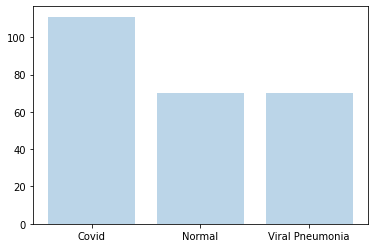

In [ ]:
def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(train_ds)


TRAIN DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 221
Counts: {'Covid': 97, 'Normal': 65, 'Viral Pneumonia': 59}

VALIDATION DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 30
Counts: {'Covid': 14, 'Normal': 5, 'Viral Pneumonia': 11}

TEST DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 66
Counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


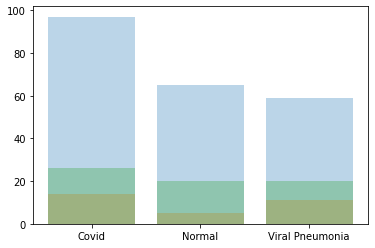

In [ ]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed);

val_size = 30
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

print("\nTRAIN DATASET")
_=describe_dataset(train_ds)

print("\nVALIDATION DATASET")
_=describe_dataset(val_ds)

print("\nTEST DATASET")
_=describe_dataset(test_ds)

dataset = None
new_dataset = None

In [ ]:
batch_size = 5

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of validation batches', len(valid_loader))
print('Number of test batches', len(test_loader))

Number of training batches 45
Number of validation batches 6
Number of test batches 14


In [ ]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{classes[int(preds[i].numpy())]}', color=col)
        if(i==5):
            break
    plt.tight_layout()
    plt.show()

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


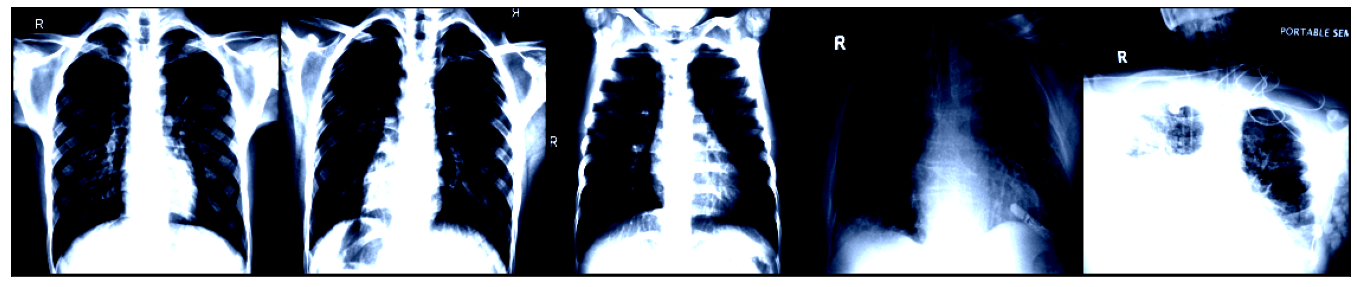

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

# TRAINING AND TESTING METRICS

In [ ]:
def change_device(input):
    if torch.cuda.is_available():
        return input.cuda()
    else:
        return input

In [ ]:
def train(model, train_loader):
    
    model.train()
    
    epoch_loss = 0

    for train_step, (images, labels) in enumerate(train_loader):

        x_train = change_device(images)
        y_train = change_device(labels)

        optimizer.zero_grad()
        
        y_pred = model(x_train)
        
        loss = loss_fn(y_pred,y_train)
        
        loss.backward()
        
        optimizer.step()

        if(train_step%20==0):
            print(f"batch:   {train_step}   train_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
        epoch_loss += loss.item()
        
    return epoch_loss / (train_step +1 )

In [ ]:
def evaluate(model, loader):
    
    model.eval()
    print("validation/test set evaluation")
    epoch_loss = 0
    
    with torch.no_grad():
        accuracy = 0
        for val_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
            accuracy += sum(( preds.cpu() == labels).numpy())

            if(val_step%3==0):
                print(f"batch:   {val_step}   validation_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
            epoch_loss += loss.item()
        accuracy = accuracy/len(val_ds)
        print(f' Accuracy: {accuracy:.4f}')

    return epoch_loss / (val_step + 1)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def show_preds(model,loader):
    model.eval() 
    print("test set evaluation")

    with torch.no_grad():
        accuracy = 0
        for test_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
          
            accuracy += sum(( preds.cpu() == labels).numpy())
        accuracy = accuracy/len(test_ds)
        print(f' Accuracy: {accuracy:.4f}')

    show_images(images, labels, preds.cpu())

# ResNet

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

In [ ]:
model = resnet18.cuda()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 11,178,051 trainable parameters and total memory usage is 127.92264175415039 mb


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.1831443309783936   perplexity   = 3.2646231651306152
batch:   20   train_loss   0.5150789618492126   perplexity   = 1.6737706661224365
batch:   40   train_loss   0.22861328721046448   perplexity   = 1.256855845451355
validation/test set evaluation
batch:   0   validation_loss   0.3504717946052551   perplexity   = 1.4197372198104858
batch:   3   validation_loss   0.17226579785346985   perplexity   = 1.1879935264587402
 Accuracy: 0.9667
saving the model
Epoch: 01 | Time: 0m 12s
	Train Loss: 0.634 | Train PPL:   1.884
	 Val. Loss: 0.147 |  Val. PPL:   1.159


test set evaluation
 Accuracy: 0.9242


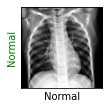

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.24147705733776093   perplexity   = 1.2731282711029053
batch:   20   train_loss   0.34413301944732666   perplexity   = 1.4107662439346313
batch:   40   train_loss   0.45473870635032654   perplexity   = 1.5757616758346558
validation/test set evaluation
batch:   0   validation_loss   0.024469763040542603   perplexity   = 1.0247716903686523
batch:   3   validation_loss   0.051733266562223434   perplexity   = 1.0530948638916016
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 12s
	Train Loss: 0.292 | Train PPL:   1.340
	 Val. Loss: 0.069 |  Val. PPL:   1.071
batch:   0   train_loss   0.035021211951971054   perplexity   = 1.0356416702270508
batch:   20   train_loss   0.20493897795677185   perplexity   = 1.2274502515792847
batch:   40   train_loss   0.023220157250761986   perplexity   = 1.0234918594360352
validation/test set evaluation
batch:   0   validation_loss   0.01720055565237999   perplexity   = 1.017349362373352
batch:   3   validation_loss   0.01827

test set evaluation
 Accuracy: 0.9848


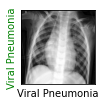

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.1773454248905182   perplexity   = 1.194043517112732
batch:   20   train_loss   0.10531574487686157   perplexity   = 1.1110613346099854
batch:   40   train_loss   0.5276926159858704   perplexity   = 1.6950167417526245
validation/test set evaluation
batch:   0   validation_loss   0.011513734236359596   perplexity   = 1.011580228805542
batch:   3   validation_loss   0.08105474710464478   perplexity   = 1.0844303369522095
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.185 | Train PPL:   1.203
	 Val. Loss: 0.025 |  Val. PPL:   1.026
batch:   0   train_loss   0.09403765201568604   perplexity   = 1.0986011028289795
batch:   20   train_loss   0.15150021016597748   perplexity   = 1.1635785102844238
batch:   40   train_loss   0.018314151093363762   perplexity   = 1.0184829235076904
validation/test set evaluation
batch:   0   validation_loss   0.0024461362045258284   perplexity   = 1.0024491548538208
batch:   3   validation_loss   0.00627560

test set evaluation
 Accuracy: 0.9848


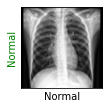

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.15911699831485748   perplexity   = 1.1724750995635986
batch:   20   train_loss   0.1267535537481308   perplexity   = 1.1351372003555298
batch:   40   train_loss   0.024760423228144646   perplexity   = 1.0250694751739502
validation/test set evaluation
batch:   0   validation_loss   0.004029599018394947   perplexity   = 1.0040377378463745
batch:   3   validation_loss   0.010710555128753185   perplexity   = 1.010768175125122
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.125 | Train PPL:   1.133
	 Val. Loss: 0.011 |  Val. PPL:   1.011
batch:   0   train_loss   0.23017863929271698   perplexity   = 1.2588248252868652
batch:   20   train_loss   0.12815745174884796   perplexity   = 1.1367319822311401
batch:   40   train_loss   0.01029808260500431   perplexity   = 1.010351300239563
validation/test set evaluation
batch:   0   validation_loss   0.00427423557266593   perplexity   = 1.0042834281921387
batch:   3   validation_loss   0.00233402

test set evaluation
 Accuracy: 0.9848


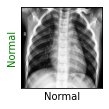

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
show_preds(model, test_loader)

# DENSENET PRETRAINED

In [ ]:
densenet121 = torchvision.models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.averagepool = nn.AdaptiveAvgPool2d(1)
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Linear(in_features=1024, out_features=3)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
model = change_device(DenseNet(densenet121))

In [ ]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 1, 1]) parameters are 8192
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([96]) parameters are 96
 torch.Size([96]) parameters are 96
 torch.Size([128, 96, 1, 1]) parameters are 12288
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 128, 1, 1]) parameters are 16384
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([160]) parameters are 160
 torch.Size([160]) parameters are 160
 torch.Size([128, 160, 1, 1]) parameters are 20480
 torch

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 7,981,931 trainable parameters and total memory usage is 91.34595108032227 mb


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.9694177508354187   perplexity   = 2.636409044265747
batch:   20   train_loss   0.7132372856140137   perplexity   = 2.040586471557617
batch:   40   train_loss   0.7217923402786255   perplexity   = 2.0581188201904297
validation/test set evaluation
batch:   0   validation_loss   0.2369183748960495   perplexity   = 1.267337679862976
batch:   3   validation_loss   0.3748834729194641   perplexity   = 1.4548219442367554
 Accuracy: 0.9667
saving the model
Epoch: 01 | Time: 0m 13s
	Train Loss: 0.757 | Train PPL:   2.132
	 Val. Loss: 0.314 |  Val. PPL:   1.369


In [ ]:
model.load_state_dict(torch.load('model_1_densenet_pretrained_cam.pt'))

<All keys matched successfully>

test set evaluation
 Accuracy: 0.9091


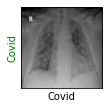

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.4412691593170166   perplexity   = 1.5546791553497314
batch:   20   train_loss   0.1467139720916748   perplexity   = 1.1580227613449097
batch:   40   train_loss   0.27215737104415894   perplexity   = 1.312793493270874
validation/test set evaluation
batch:   0   validation_loss   0.19056500494480133   perplexity   = 1.2099330425262451
batch:   3   validation_loss   0.2843248248100281   perplexity   = 1.3288644552230835
 Accuracy: 0.9667
saving the model
Epoch: 01 | Time: 0m 13s
	Train Loss: 0.309 | Train PPL:   1.362
	 Val. Loss: 0.168 |  Val. PPL:   1.182
batch:   0   train_loss   0.3175528943538666   perplexity   = 1.3737618923187256
batch:   20   train_loss   0.06126798316836357   perplexity   = 1.0631837844848633
batch:   40   train_loss   0.08207167685031891   perplexity   = 1.085533618927002
validation/test set evaluation
batch:   0   validation_loss   0.08377819508314133   perplexity   = 1.0873876810073853
batch:   3   validation_loss   0.20411638915538

test set evaluation
 Accuracy: 0.9697


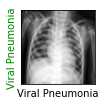

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.283923864364624   perplexity   = 1.3283318281173706
batch:   20   train_loss   1.1806678771972656   perplexity   = 3.2565484046936035
batch:   40   train_loss   0.24582526087760925   perplexity   = 1.278676152229309
validation/test set evaluation
batch:   0   validation_loss   0.1569075733423233   perplexity   = 1.1698874235153198
batch:   3   validation_loss   0.026303544640541077   perplexity   = 1.026652455329895
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 13s
	Train Loss: 0.284 | Train PPL:   1.329
	 Val. Loss: 0.063 |  Val. PPL:   1.065
batch:   0   train_loss   0.1279604732990265   perplexity   = 1.1365081071853638
batch:   20   train_loss   0.168111652135849   perplexity   = 1.1830687522888184
batch:   40   train_loss   0.2949077785015106   perplexity   = 1.343002438545227
validation/test set evaluation
batch:   0   validation_loss   0.17434042692184448   perplexity   = 1.1904608011245728
batch:   3   validation_loss   0.032266538590192795

test set evaluation
 Accuracy: 0.9697


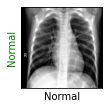

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.04332287237048149   perplexity   = 1.0442750453948975
batch:   20   train_loss   0.01236777938902378   perplexity   = 1.0124444961547852
batch:   40   train_loss   0.021718580275774002   perplexity   = 1.021956205368042
validation/test set evaluation
batch:   0   validation_loss   0.0685112327337265   perplexity   = 1.0709125995635986
batch:   3   validation_loss   0.02508925274014473   perplexity   = 1.0254065990447998
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 17s
	Train Loss: 0.162 | Train PPL:   1.176
	 Val. Loss: 0.027 |  Val. PPL:   1.028
batch:   0   train_loss   0.03073297068476677   perplexity   = 1.0312100648880005
batch:   20   train_loss   0.030280232429504395   perplexity   = 1.0307433605194092
batch:   40   train_loss   0.12611176073551178   perplexity   = 1.134408950805664
validation/test set evaluation
batch:   0   validation_loss   0.01902182772755623   perplexity   = 1.0192039012908936
batch:   3   validation_loss   0.014801448

test set evaluation
 Accuracy: 0.9697


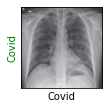

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.27459487318992615   perplexity   = 1.3159974813461304
batch:   20   train_loss   0.0035264689940959215   perplexity   = 1.0035327672958374
batch:   40   train_loss   0.0018750873859971762   perplexity   = 1.0018768310546875
validation/test set evaluation
batch:   0   validation_loss   0.03008100762963295   perplexity   = 1.0305380821228027
batch:   3   validation_loss   0.01589457131922245   perplexity   = 1.016021490097046
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 18s
	Train Loss: 0.104 | Train PPL:   1.109
	 Val. Loss: 0.017 |  Val. PPL:   1.017
batch:   0   train_loss   0.034953560680150986   perplexity   = 1.035571575164795
batch:   20   train_loss   0.022281287238001823   perplexity   = 1.0225313901901245
batch:   40   train_loss   0.01568986102938652   perplexity   = 1.0158135890960693
validation/test set evaluation
batch:   0   validation_loss   0.001899286755360663   perplexity   = 1.0019011497497559
batch:   3   validation_loss   0.001

test set evaluation
 Accuracy: 0.9394


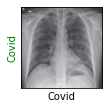

In [ ]:
show_preds(model, test_loader)

# VGG

In [ ]:
class VGGNet(nn.Module):
    def __init__ (self):
        super(VGGNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1) #224
        self.maxPool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1) #112
        self.maxPool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1) #56
        self.maxPool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1) #28
        self.maxPool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,padding=0,stride=1)
        self.maxPool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1) #14
        self.maxPool6 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(4608,1024) #7
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,3)

    def forward(self , x):
               
        x = self.maxPool1(F.relu(self.conv1(x)))

        x = self.maxPool2(F.relu(self.conv2(x)))

        x = self.maxPool3(F.relu(self.conv3(x)))

        x = self.maxPool4(F.relu(self.conv4(x)))

        x = self.maxPool5(F.relu(self.conv5(x)))

        x = self.maxPool6(F.relu(self.conv6(x)))

        x = x.reshape(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x


In [ ]:
model = change_device(VGGNet())

In [ ]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 3, 3]) parameters are 1728
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size([128]) parameters are 128
 torch.Size([256, 128, 3, 3]) parameters are 294912
 torch.Size([256]) parameters are 256
 torch.Size([512, 256, 3, 3]) parameters are 1179648
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 1, 1]) parameters are 262144
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 3, 3]) parameters are 2359296
 torch.Size([512]) parameters are 512
 torch.Size([1024, 4608]) parameters are 4718592
 torch.Size([1024]) parameters are 1024
 torch.Size([512, 1024]) parameters are 524288
 torch.Size([512]) parameters are 512
 torch.Size([3, 512]) parameters are 1536
 torch.Size([3]) parameters are 3


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 9,419,395 trainable parameters and total memory usage is 107.79642105102539 mb


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.101744532585144   perplexity   = 3.009411573410034
batch:   20   train_loss   1.1009515523910522   perplexity   = 3.007025957107544
batch:   40   train_loss   1.0098987817764282   perplexity   = 2.7453231811523438
validation/test set evaluation
batch:   0   validation_loss   1.0644251108169556   perplexity   = 2.899171829223633
batch:   3   validation_loss   0.9771503210067749   perplexity   = 2.656874179840088
 Accuracy: 0.5000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 1.084 | Train PPL:   2.955
	 Val. Loss: 1.045 |  Val. PPL:   2.843


In [ ]:
model.load_state_dict(torch.load('model_2.pt'))

<All keys matched successfully>

test set evaluation
 Accuracy: 0.3939


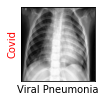

In [ ]:
show_preds(model, test_loader) 

In [ ]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.0986123085021973   perplexity   = 3.0
batch:   20   train_loss   1.0986123085021973   perplexity   = 3.0
batch:   40   train_loss   1.0986123085021973   perplexity   = 3.0
validation/test set evaluation
batch:   0   validation_loss   1.0986123085021973   perplexity   = 3.0
batch:   3   validation_loss   1.0986123085021973   perplexity   = 3.0
 Accuracy: 0.4667
saving the model
Epoch: 01 | Time: 0m 14s
	Train Loss: 1.099 | Train PPL:   3.000
	 Val. Loss: 1.099 |  Val. PPL:   3.000
batch:   0   train_loss   1.0986123085021973   perplexity   = 3.0
batch:   20   train_loss   1.0986123085021973   perplexity   = 3.0
batch:   40   train_loss   1.0986123085021973   perplexity   = 3.0
validation/test set evaluation
batch:   0   validation_loss   1.0986123085021973   perplexity   = 3.0
batch:   3   validation_loss   1.0986123085021973   perplexity   = 3.0
 Accuracy: 0.4667
Epoch: 02 | Time: 0m 14s
	Train Loss: 1.099 | Train PPL:   3.000
	 Val. Loss: 1.099 |  Val. PPL:

test set evaluation
 Accuracy: 0.3939


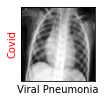

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 3

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.1191326379776   perplexity   = 3.062196969985962
batch:   20   train_loss   0.723706841468811   perplexity   = 2.062062978744507
batch:   40   train_loss   1.4567328691482544   perplexity   = 4.291914463043213
validation/test set evaluation
batch:   0   validation_loss   0.580288290977478   perplexity   = 1.7865533828735352
batch:   3   validation_loss   0.9775434732437134   perplexity   = 2.657918930053711
 Accuracy: 0.8000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.799 | Train PPL:   2.223
	 Val. Loss: 0.562 |  Val. PPL:   1.754
batch:   0   train_loss   1.2905642986297607   perplexity   = 3.6348371505737305
batch:   20   train_loss   0.3947065770626068   perplexity   = 1.4839487075805664
batch:   40   train_loss   0.4380820691585541   perplexity   = 1.5497320890426636
validation/test set evaluation
batch:   0   validation_loss   0.3286864161491394   perplexity   = 1.3891420364379883
batch:   3   validation_loss   0.0697760060429573   perplex

test set evaluation
 Accuracy: 0.6667


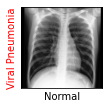

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.09682191163301468   perplexity   = 1.1016641855239868
batch:   20   train_loss   0.4324265420436859   perplexity   = 1.5409923791885376
batch:   40   train_loss   0.18386854231357574   perplexity   = 1.2018578052520752
validation/test set evaluation
batch:   0   validation_loss   0.5069385766983032   perplexity   = 1.660200834274292
batch:   3   validation_loss   0.2177625596523285   perplexity   = 1.2432917356491089
 Accuracy: 0.8333
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.581 | Train PPL:   1.788
	 Val. Loss: 0.314 |  Val. PPL:   1.368
batch:   0   train_loss   0.32141944766044617   perplexity   = 1.3790838718414307
batch:   20   train_loss   0.03225910663604736   perplexity   = 1.0327850580215454
batch:   40   train_loss   0.4644905924797058   perplexity   = 1.5912033319473267
validation/test set evaluation
batch:   0   validation_loss   0.5587252378463745   perplexity   = 1.74844229221344
batch:   3   validation_loss   0.2184930741786956

test set evaluation
 Accuracy: 0.6515


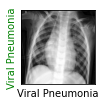

In [ ]:
show_preds(model, test_loader)

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.4140240252017975   perplexity   = 1.512893557548523
batch:   20   train_loss   0.45479145646095276   perplexity   = 1.575844645500183
batch:   40   train_loss   0.6969411969184875   perplexity   = 2.0076024532318115
validation/test set evaluation
batch:   0   validation_loss   0.34789398312568665   perplexity   = 1.4160820245742798
batch:   3   validation_loss   0.31161436438560486   perplexity   = 1.3656280040740967
 Accuracy: 0.8000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.479 | Train PPL:   1.614
	 Val. Loss: 0.406 |  Val. PPL:   1.501
batch:   0   train_loss   0.682750403881073   perplexity   = 1.9793142080307007
batch:   20   train_loss   0.4616609513759613   perplexity   = 1.5867072343826294
batch:   40   train_loss   0.47948113083839417   perplexity   = 1.6152361631393433
validation/test set evaluation
batch:   0   validation_loss   0.03333968669176102   perplexity   = 1.0339016914367676
batch:   3   validation_loss   0.222592979669570

test set evaluation
 Accuracy: 0.6515


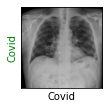

In [ ]:
show_preds(model, test_loader)

## PLOT

In [ ]:
import plotly.figure_factory as ff

data_matrix = [['Classes','Data_available'],
               ['Normal', 70],
               ['Viral_Pneumonia', 70],
               ['Covid', 111]]

colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

fig = ff.create_table(data_matrix,colorscale=colorscale)
fig.update_layout(
    title_text = 'Data used for training',
    margin = {'t':40},
    height = 200,
    title_x=0.5
)
fig.show()